In [237]:
# Import built-in libraries
import os
from os.path import abspath

# Import external libraries
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [41]:
# Load all data
demo = pd.read_csv(abspath("../data/T_demo.csv"))
stage = pd.read_csv(abspath("../data/T_stage.csv"))

# Biomarkers
cre = pd.read_csv(abspath("../data/T_creatinine.csv"))
dbp = pd.read_csv(abspath("../data/T_DBP.csv"))
sbp = pd.read_csv(abspath("../data/T_SBP.csv"))
hgb = pd.read_csv(abspath("../data/T_HGB.csv"))
glu = pd.read_csv(abspath("../data/T_glucose.csv"))
ldl = pd.read_csv(abspath("../data/T_ldl.csv"))

# Medication
meds = pd.read_csv(abspath("../data/T_meds.csv"))

id        False
race      False
gender    False
age       False
dtype: bool
id                False
Stage_Progress    False
dtype: bool
id       False
value    False
time     False
dtype: bool
id       False
value    False
time     False
dtype: bool
id       False
value    False
time     False
dtype: bool
id       False
value    False
time     False
dtype: bool
id       False
value    False
time     False
dtype: bool
id       False
value    False
time     False
dtype: bool
id              False
drug            False
daily_dosage    False
start_day       False
end_day         False
dtype: bool


In [145]:
# Group values by patient id
# Calculate the difference between the latest and first measurement for all biomarkers
cre_s = pd.Series({i:(data.iloc[-1]-data.iloc[0]).value for i, data in cre.groupby("id")}, name="cre")
dbp_s = pd.Series({i:(data.iloc[-1]-data.iloc[0]).value for i, data in dbp.groupby("id")}, name="dbp")
sbp_s = pd.Series({i:(data.iloc[-1]-data.iloc[0]).value for i, data in sbp.groupby("id")}, name="sbp")
hgb_s = pd.Series({i:(data.iloc[-1]-data.iloc[0]).value for i, data in hgb.groupby("id")}, name="hgb")
glu_s = pd.Series({i:(data.iloc[-1]-data.iloc[0]).value for i, data in glu.groupby("id")}, name="glu")
ldl_s = pd.Series({i:(data.iloc[-1]-data.iloc[0]).value for i, data in ldl.groupby("id")}, name="ldl")


# Create a new data frame with the differences
biomarkers_diff = pd.concat([demo, cre_s, dbp_s, sbp_s, hgb_s, glu_s, ldl_s], axis=1)

In [146]:
# Binarize medication labels
# First let's create a dataframe with drugs as columns
meds_bin = pd.DataFrame()

# Iterate over the medications table grouping it by drug
for i,data in meds.groupby("drug"):
    
    # Create an empty array
    drug = np.zeros(demo.id.shape, dtype=bool)
    
    # For each drug, get the patients that are taking it
    # Change the value of the array to true only for the patients takin the drug
    drug[data.id.unique()]=True
    
    # Add a column for the specific drug to the binarized meds dataframe
    meds_bin[i]=drug

In [147]:
meds_bin

,atenolol,atorvastatin,bisoprolol,canagliflozin,carvedilol,dapagliflozin,irbesartan,labetalol,losartan,lovastatin,...,metoprolol,nebivolol,olmesartan,pitavastatin,pravastatin,propranolol,rosuvastatin,simvastatin,telmisartan,valsartan
0,False,True,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
1,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
296,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
297,False,False,False,False,False,False,True,False,False,False,...,True,False,False,True,False,False,False,False,False,True
298,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [293]:
# Now let's merge together the biomarkers_diff dataframe
# and the meds_bin dataframe
predictors = pd.concat([biomarkers_diff.drop("id", axis=1), meds_bin], axis=1)
target = stage.drop("id", axis=1)

In [301]:
# Split between train and validation
X_train, X_test, y_train, y_test = train_test_split(predictors.drop(["race", "gender"],axis=1), target, test_size=0.1, random_state=43)

In [302]:
%%time
# Train a random forest 
model = RandomForestClassifier(bootstrap=True, n_estimators=10000, n_jobs=-1)
model.fit(X_train, y_train.values.ravel())

CPU times: user 29.6 s, sys: 10.3 s, total: 39.9 s
Wall time: 24.4 s


RandomForestClassifier(n_estimators=10000, n_jobs=-1)

In [303]:
model.score(X_test, y_test)

0.9333333333333333

In [304]:
predicted = model.predict(X_test)

In [305]:
cm = confusion_matrix(y_test, predicted)

In [306]:
def plot_confusion_matrix(cm):
    fig, ax = plt.subplots(1, 1, figsize=(8,8))
    sns.heatmap(cm, ax=ax, annot=True)
    ax.set_xlabel("predicted")
    ax.set_ylabel("true")

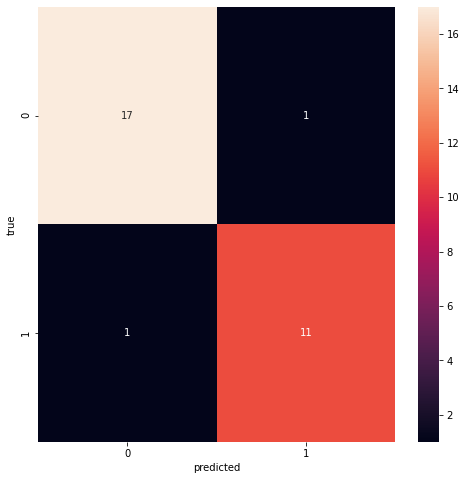

In [307]:
plot_confusion_matrix(cm)